In [1]:
import random
import sys
from typing import Dict

sys.path.append("..")

import os
import time

import matplotlib.pyplot as plt
import numpy as np

# Data analysis and visualization
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

from src.game.yahtzee_game import YahtzeeGame
from src.strategies.base_strategy import BaseStrategy
from src.strategies.expected_value_strategy import ExpectedValueStrategy
from src.strategies.expected_value_v2_strategy import ExpectedValueV2Strategy
from src.strategies.gemini_strategy import GeminiStrategy
from src.strategies.random_strategy import RandomStrategy
from src.strategies.rule_based_strategy import RuleBasedStrategy
from src.strategies.user_input_strategy import UserInputStrategy

if not load_dotenv():
    raise RuntimeError("Failed to load environment variables from .env file")

C:\tools\Manim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
random.seed(SEED)

DEBUG = False

STRATEGIES: Dict[str, BaseStrategy] = {
    "Gemini": GeminiStrategy(os.environ["GOOGLE_API_KEY"]),
    "ExpectedV2": ExpectedValueV2Strategy(),
    "Expected": ExpectedValueStrategy(),
    "Rule": RuleBasedStrategy(),
    "Random": RandomStrategy(),
    # "User": UserInputStrategy(),
}

Initializing lookup tables for ExpectedValueStrategy...
Computing third roll values...
Computing second roll values...
Computing first roll values...
Lookup tables initialized!


In [ ]:
print("Welcome to the Yahtzee Simulator!\n")
game = YahtzeeGame()

# Initialize game history tracking
game.game_history = []
game.round_number = 0

for name, strategy in STRATEGIES.items():
    print(f"Adding player: {name} with strategy {strategy.__class__.__name__}")
    game.add_player(name)

# Play the game
print("\nStarting game...\n")

while not game.is_game_over():
    start_time = time.time()
    current_player = game.current_player()
    print(f"\nCurrent player: {current_player.name}")
    
    # Track round data
    round_data = {
        "player": current_player.name,
        "dice_rolls": [],
        "kept_dice": [],
        "round": game.round_number,
    }

    # First roll is automatic
    dice = game.roll_dice()

    round_data["dice_rolls"].append(list(dice))
    print(f"Roll #1: {dice}")

    # Use strategy for rerolls and scoring
    strategy = STRATEGIES[current_player.name]

    # Second roll
    if game.roll_count < 3:

        dice_index_to_keep = strategy.select_dice_to_keep(
            dice, current_player.scorecard, debug=DEBUG
        )
        dice_to_keep = [dice[i] for i in dice_index_to_keep]
        round_data["kept_dice"].append(list(dice_index_to_keep))

        print(
            f"Keeping dice at positions: {dice_index_to_keep or 'none'} | {dice_to_keep}"
        )

        dice = game.roll_dice(dice_index_to_keep)

        round_data["dice_rolls"].append(list(dice))
        print(f"Roll #2: {dice}")


    # Third roll
    if game.roll_count < 3:

        dice_index_to_keep = strategy.select_dice_to_keep(
            dice, current_player.scorecard, debug=DEBUG
        )
        dice_to_keep = [dice[i] for i in dice_index_to_keep]
        round_data["kept_dice"].append(list(dice_index_to_keep))
        print(
            f"Keeping dice at positions: {dice_index_to_keep or 'none'} | {dice_to_keep}"
        )

        dice = game.roll_dice(dice_index_to_keep)

        round_data["dice_rolls"].append(list(dice))
        print(f"Roll #3: {dice}")


    # Score the roll

    category = strategy.select_category(dice, current_player.scorecard, debug=DEBUG)
    score = current_player.scorecard.calculate_score(category, dice)
    print(f"Scoring {score} in {category.name} ({time.time() - start_time:.3f}s)")

    # Store category and score in round data
    round_data["category"] = category.name
    round_data["score"] = score
    game.select_score(category)

    # Update total score after scoring
    round_data["total_score"] = current_player.get_total_score()

    # Store the round data
    game.game_history.append(round_data)

    # Check if round is complete (all players have taken their turn)
    if game.current_player_index == 0:  # The select score already increments the index
        # Display rankings after each round
        print(f"\n--- End of Round {game.round_number} ---")
        game.round_number += 1
        sorted_players = sorted(
            game.players, key=lambda p: p.get_total_score(), reverse=True
        )
        for i, player in enumerate(sorted_players, 1):
            print(f"{i}. {player.name}: {player.get_total_score()} points")

# Game over - show results
print("\nGame over!")
print("\n--- FINAL STANDINGS ---")
sorted_players = sorted(game.players, key=lambda p: p.get_total_score(), reverse=True)
for i, player in enumerate(sorted_players, 1):
    print(f"{i}. {player.name}: {player.get_total_score()} points")

winner = game.determine_winner()
print(f"\nThe winner is {winner}!")

Welcome to the Yahtzee Simulator!

Adding player: Gemini with strategy GeminiStrategy
Adding player: ExpectedV2 with strategy ExpectedValueV2Strategy
Adding player: Expected with strategy ExpectedValueStrategy
Adding player: Rule with strategy RuleBasedStrategy
Adding player: Random with strategy RandomStrategy

Starting game...


Current player: Gemini
Roll #1: [1, 6, 3, 2, 2]
Keeping dice at positions: {0, 2, 3, 4} | [1, 3, 2, 2]
Roll #2: [1, 1, 3, 2, 2]
Keeping dice at positions: {0, 1, 3, 4} | [1, 1, 2, 2]
Roll #3: [1, 1, 5, 2, 2]
Scoring 2 in ONES (109.748s)

Current player: ExpectedV2
Roll #1: [4, 1, 1, 1, 2]
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"st

In [4]:
# Convert game history to DataFrame
history_df = pd.DataFrame(game.game_history)

# Create a detailed scorecard table for all players
print("FINAL SCORECARD ANALYSIS")
scorecard_data = {}

for player in game.players:
    # Get all categories from the scorecard
    categories = [cat.name for cat in player.scorecard.scores.keys()]
    scores = [player.scorecard.get_score(cat) for cat in player.scorecard.scores.keys()]

    # Create a dictionary of category:score
    player_data = dict(zip(categories, scores))

    player_data["Total Score"] = player.get_total_score()

    scorecard_data[player.name] = player_data

# Convert to DataFrame and display
scorecard_df = pd.DataFrame(scorecard_data)
display(scorecard_df)


FINAL SCORECARD ANALYSIS


,Gemini,ExpectedV2,Expected,Rule,Random
ONES,1,0,0,1,1
TWOS,0,4,4,2,0
THREES,0,6,6,9,0
FOURS,0,4,8,0,0
FIVES,5,0,10,20,5
SIXES,0,18,12,24,12
THREE_OF_A_KIND,25,27,0,22,14
FOUR_OF_A_KIND,0,18,0,0,0
FULL_HOUSE,0,25,25,25,0
SMALL_STRAIGHT,30,30,30,0,0


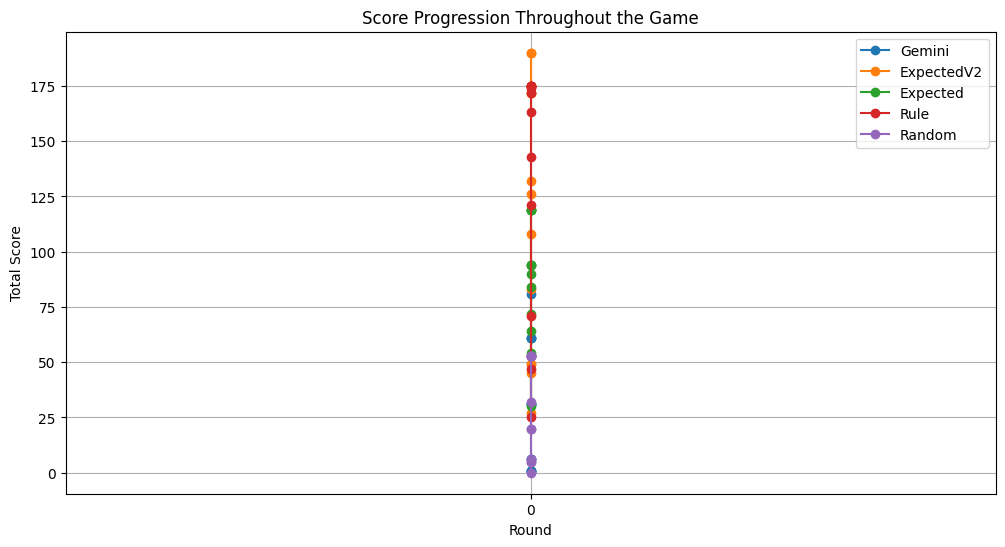

In [5]:
# Create score progression chart
plt.figure(figsize=(12, 6))
for player in game.players:
    player_data = history_df[history_df["player"] == player.name].sort_values("round")

    # Calculate cumulative scores for each turn
    scores = []
    total = 0
    for _, row in player_data.iterrows():
        total = row["total_score"]
        scores.append(total)

    rounds = player_data["round"].tolist()
    plt.plot(rounds, scores, marker="o", label=player.name)

plt.title("Score Progression Throughout the Game")
plt.xlabel("Round")
plt.ylabel("Total Score")
plt.legend()
plt.grid(True)
plt.xticks(range(max(history_df["round"]) + 1))
plt.show()


In [ ]:

# Create ranking progression chart
plt.figure(figsize=(12, 6))

# Get unique rounds
rounds = sorted(history_df["round"].unique())
max_round = max(rounds)

# Calculate rankings for each round
rankings_by_round = {}
for r in range(max_round + 1):
    # Get data up to this round
    round_data = history_df[history_df["round"] <= r]

    # Get latest score for each player by this round
    player_scores = {}
    for player in game.players:
        player_rounds = round_data[round_data["player"] == player.name]
        if not player_rounds.empty:
            latest_score = player_rounds.iloc[-1]["total_score"]
            player_scores[player.name] = latest_score
        else:
            player_scores[player.name] = 0

    # Calculate rankings
    sorted_players = sorted(player_scores.items(), key=lambda x: x[1], reverse=True)
    rankings_by_round[r] = {
        player: i + 1 for i, (player, _) in enumerate(sorted_players)
    }

# Plot ranking changes
for player in game.players:
    player_rankings = [
        rankings_by_round[r].get(player.name, len(game.players))
        for r in range(max_round + 1)
    ]
    plt.plot(range(max_round + 1), player_rankings, marker="o", label=player.name)

plt.title("Player Rankings Throughout the Game")
plt.xlabel("Round")
plt.ylabel("Rank")
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # Rank 1 at the top
plt.xticks(range(max_round + 1))
plt.yticks(range(1, len(game.players) + 1))
plt.show()


In [ ]:

# Create category score comparison chart
plt.figure(figsize=(14, 8))
category_scores = {p.name: [] for p in game.players}
category_names = [
    cat
    for cat in scorecard_df.index
    if cat not in ["Upper Subtotal", "Upper Bonus", "Total Score"]
]

for player in game.players:
    for cat in category_names:
        category_scores[player.name].append(scorecard_df.loc[cat, player.name])

# Plot category comparison
width = 0.8 / len(game.players)
x = np.arange(len(category_names))

for i, player in enumerate(game.players):
    plt.bar(
        x + i * width - width * (len(game.players) - 1) / 2,
        category_scores[player.name],
        width=width,
        label=player.name,
    )

plt.title("Category Score Comparison")
plt.ylabel("Score")
plt.xlabel("Category")
plt.xticks(x, category_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis="y")
plt.show()


In [ ]:

# Add statistics about dice selection and strategy effectiveness
print("\nSTRATEGY ANALYSIS")

# Calculate average score by category for each player
for player in game.players:
    player_data = history_df[history_df["player"] == player.name]
    print(f"\n{player.name}'s Strategy Performance:")
    category_avg = player_data.groupby("category")["score"].mean()
    print(f"Average score by category:\n{category_avg}")

    # Calculate reroll effectiveness
    reroll_counts = player_data.apply(lambda x: len(x["dice_rolls"]) - 1, axis=1).mean()
    print(f"Average number of rerolls: {reroll_counts:.2f}")

    # Most frequently selected category
    most_frequent = player_data["category"].value_counts().idxmax()
    print(f"Most frequently selected category: {most_frequent}")